# Control 

In [ ]:
import torch
from neuromancer.system import Node, System
from neuromancer import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Double integrator

For this example we demonstrate learning control for a double integrator system. In this case we learn the control from directly interacting with the system in a typical RL scenario. 

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [ ]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# closed loop system definition
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
cl_system = System([policy, double_integrator])
cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [ ]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [ ]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 5. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps

In [17]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=500,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

epoch: 0  train_loss: 21.15034294128418
epoch: 1  train_loss: 21.110309600830078
epoch: 2  train_loss: 21.073270797729492
epoch: 3  train_loss: 21.03852653503418
epoch: 4  train_loss: 21.00558853149414
epoch: 5  train_loss: 20.974136352539062
epoch: 6  train_loss: 20.944040298461914
epoch: 7  train_loss: 20.915008544921875
epoch: 8  train_loss: 20.886938095092773
epoch: 9  train_loss: 20.859783172607422
epoch: 10  train_loss: 20.83336639404297
epoch: 11  train_loss: 20.80763053894043
epoch: 12  train_loss: 20.782657623291016
epoch: 13  train_loss: 20.758378982543945
epoch: 14  train_loss: 20.734895706176758
epoch: 15  train_loss: 20.712200164794922
epoch: 16  train_loss: 20.690271377563477
epoch: 17  train_loss: 20.669055938720703
epoch: 18  train_loss: 20.648630142211914
epoch: 19  train_loss: 20.628984451293945
epoch: 20  train_loss: 20.610074996948242
epoch: 21  train_loss: 20.59185028076172
epoch: 22  train_loss: 20.574243545532227
epoch: 23  train_loss: 20.557039260864258
epoch: 2

epoch: 201  train_loss: 19.87135124206543
epoch: 202  train_loss: 19.87099266052246
epoch: 203  train_loss: 19.87063980102539
epoch: 204  train_loss: 19.87029266357422
epoch: 205  train_loss: 19.869953155517578
epoch: 206  train_loss: 19.869619369506836
epoch: 207  train_loss: 19.869287490844727
epoch: 208  train_loss: 19.868961334228516
epoch: 209  train_loss: 19.868640899658203
epoch: 210  train_loss: 19.86832618713379
epoch: 211  train_loss: 19.868013381958008
epoch: 212  train_loss: 19.867706298828125
epoch: 213  train_loss: 19.867401123046875
epoch: 214  train_loss: 19.867101669311523
epoch: 215  train_loss: 19.866811752319336
epoch: 216  train_loss: 19.866519927978516
epoch: 217  train_loss: 19.866233825683594
epoch: 218  train_loss: 19.865951538085938
epoch: 219  train_loss: 19.865673065185547
epoch: 220  train_loss: 19.865400314331055
epoch: 221  train_loss: 19.865131378173828
epoch: 222  train_loss: 19.864864349365234
epoch: 223  train_loss: 19.86460304260254
epoch: 224  train

epoch: 398  train_loss: 19.84394645690918
epoch: 399  train_loss: 19.84389877319336
epoch: 400  train_loss: 19.843852996826172
epoch: 401  train_loss: 19.84380531311035
epoch: 402  train_loss: 19.843759536743164
epoch: 403  train_loss: 19.84371566772461
epoch: 404  train_loss: 19.843664169311523
epoch: 405  train_loss: 19.843624114990234
epoch: 406  train_loss: 19.84358024597168
epoch: 407  train_loss: 19.843534469604492
epoch: 408  train_loss: 19.843490600585938
epoch: 409  train_loss: 19.843442916870117
epoch: 410  train_loss: 19.843400955200195
epoch: 411  train_loss: 19.843358993530273
epoch: 412  train_loss: 19.84331703186035
epoch: 413  train_loss: 19.843271255493164
epoch: 414  train_loss: 19.843229293823242
epoch: 415  train_loss: 19.843189239501953
epoch: 416  train_loss: 19.8431453704834
epoch: 417  train_loss: 19.843107223510742
epoch: 418  train_loss: 19.843067169189453
epoch: 419  train_loss: 19.8430233001709
epoch: 420  train_loss: 19.842985153198242
epoch: 421  train_los

# Evaluate best model on a system rollout of 50 time steps

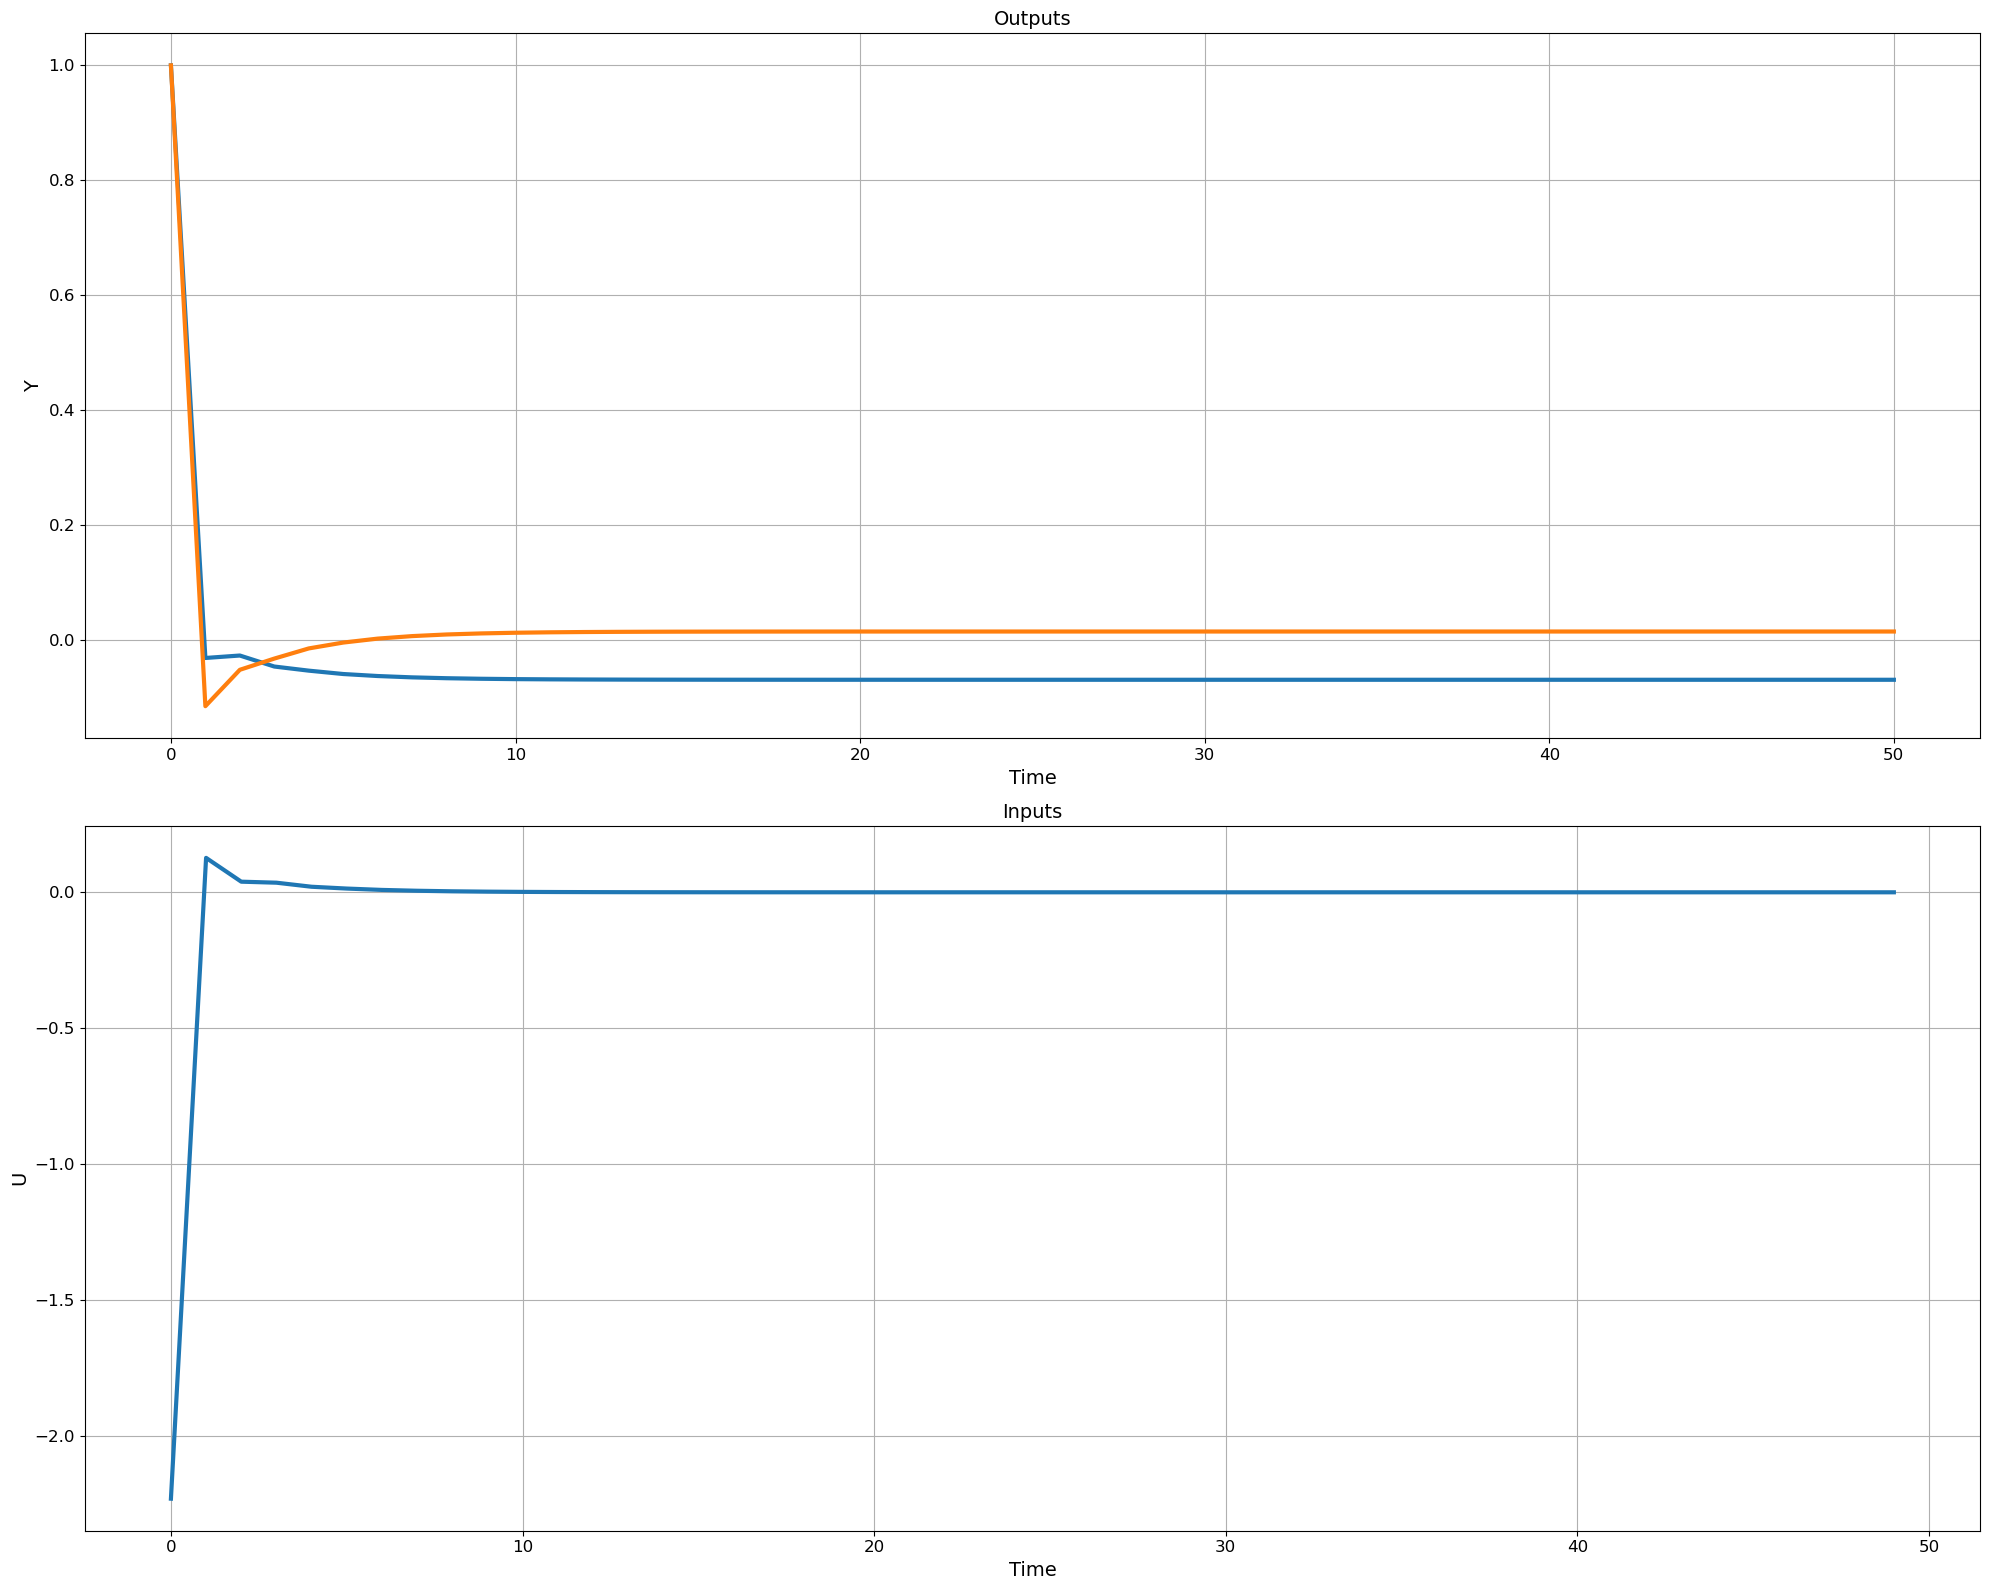

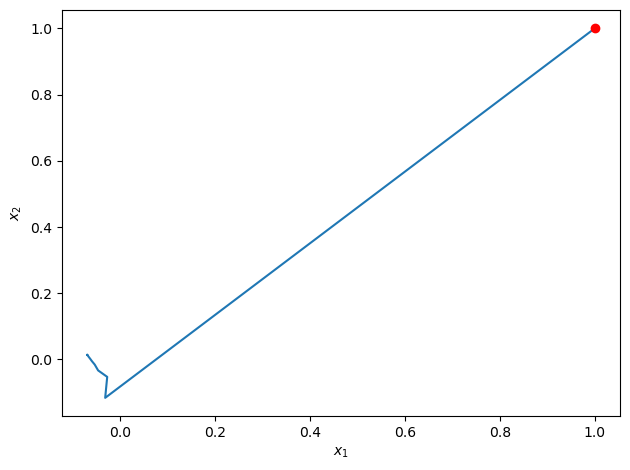

<Figure size 640x480 with 0 Axes>

In [18]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
cl_system.nsteps = 50
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(51, 2), U=trajectories['U'].detach().reshape(50, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(51, 2), figname='phase.png')

# Typical scenario. Off policy control learning

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. In this scenario, the system is perturbed for some amount of time to collect measurements representative of the system state space, system identification is performed, and a controller is created based on the fitted model created via system identification. In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

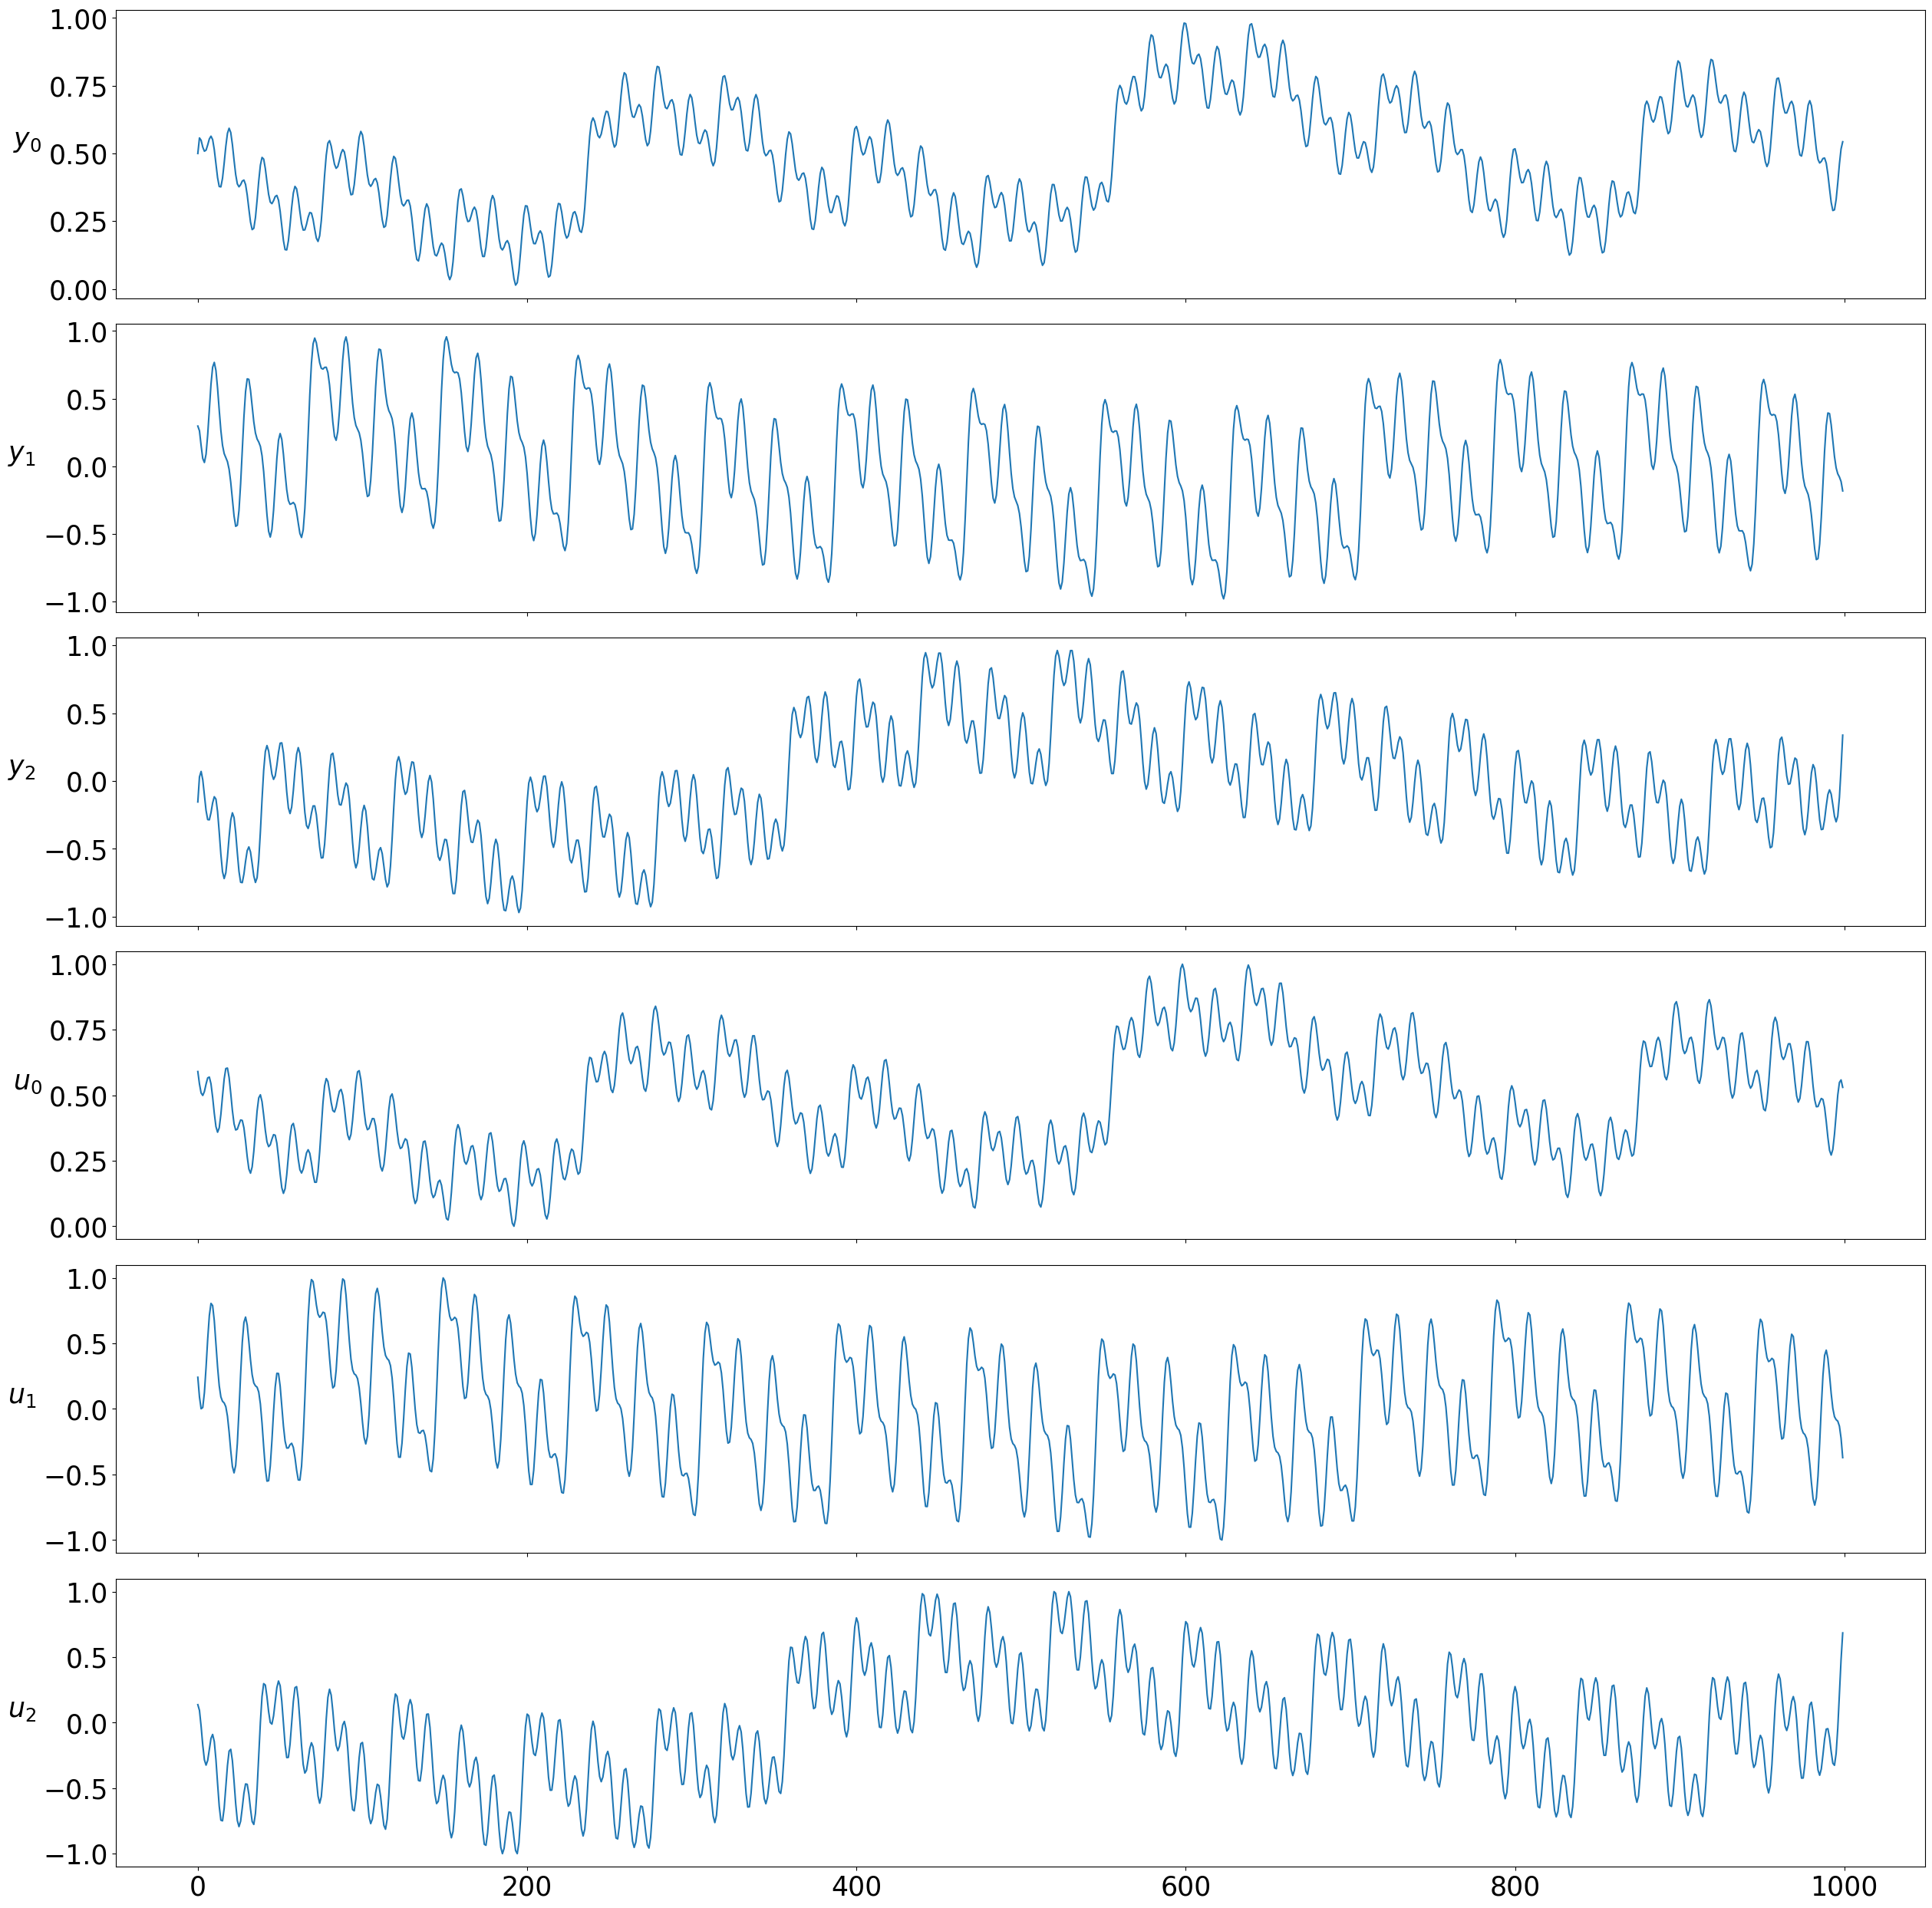

In [34]:
from neuromancer.psl.nonautonomous import Actuator

sys = Actuator()

train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]
sys.show(train_data)

from torch.utils.data import DataLoader
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
for d in [train_data, test_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :]
    d['Time'] = d['Time'].reshape(100, -1)
train_data, dev_data, test_data = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data, test_data], ['train', 'dev', 'test'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_data, dev_data, test_data]]



In [35]:
from neuromancer.system import MultipleShootingEuler, Node, System

def get_model(nx, nu, hsize, layers, ts):
    integrator = MultipleShootingEuler(nx, nu, hsize, layers, ts)
    nodes = [Node(integrator, ['X', 'xn', 'U'], ['xstep', 'xn'])]
    system = System(nodes)
    return system

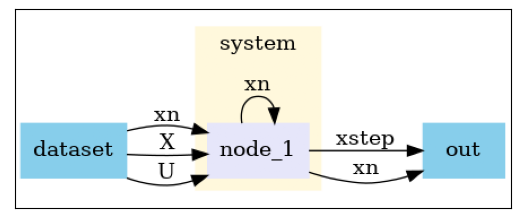

In [36]:
model = get_model(sys.nx, sys.nu, 16, 3, 0.1)
model.show()

In [38]:
import torch.optim as optim
opt = optim.Adam(model.parameters(), 0.001)

# Nstep rollout predictions from the model
xNpred = variable('xn')[:, :-1, :]
# Single step rolllout predictions from the model
x1pred = variable('xstep')
# Ground truth data
xtrue = variable('X')

lossN = (xNpred == xtrue) ^ 2
lossN.update_name('lossN')

loss1 = (x1pred == xtrue) ^ 2
loss1.update_name('loss1')

obj = PenaltyLoss([lossN, loss1], [])
problem = Problem([model], obj)

logout = ['lossN', 'loss1']
# logger = MLFlowLogger(args, 'test', stdout=['train_loss', 'dev_lossN', 'dev_loss1'], logout=logout)
trainer = Trainer(problem, train_loader, dev_loader, test_loader, opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='test_loss',
                  eval_metric='dev_lossN')
best_model = trainer.train()
# # Model training
# lr = args.lr
# nsteps = args.nsteps
# for i in range(args.iterations):
#     print(f'training {nsteps} objective, lr={lr}')
#     best_model = trainer.train()
#     trainer.model.load_state_dict(best_model)
#     lr /= 2.0
#     nsteps *= 2
#     nx, nu, train_data, dev_data, test_data = get_data(nsteps, sys, args.nsim, args.batch_size)
#     trainer.train_data, trainer.dev_data, trainer.test_data = train_data, dev_data, test_data
#     opt.param_groups[0]['lr'] = lr


epoch: 0  train_loss: 0.24111497402191162
epoch: 1  train_loss: 0.2393009066581726
epoch: 2  train_loss: 0.23748882114887238
epoch: 3  train_loss: 0.23567843437194824
epoch: 4  train_loss: 0.23386932909488678
epoch: 5  train_loss: 0.23206043243408203
epoch: 6  train_loss: 0.23025085031986237
epoch: 7  train_loss: 0.22843998670578003
epoch: 8  train_loss: 0.22662734985351562
epoch: 9  train_loss: 0.22481267154216766
epoch: 10  train_loss: 0.22299563884735107
epoch: 11  train_loss: 0.2211759239435196
epoch: 12  train_loss: 0.21935328841209412
epoch: 13  train_loss: 0.21752731502056122
epoch: 14  train_loss: 0.21569785475730896
epoch: 15  train_loss: 0.21386469900608063
epoch: 16  train_loss: 0.21202769875526428
epoch: 17  train_loss: 0.2101866900920868
epoch: 18  train_loss: 0.20834162831306458
epoch: 19  train_loss: 0.2064925879240036
epoch: 20  train_loss: 0.20463961362838745
epoch: 21  train_loss: 0.20278282463550568
epoch: 22  train_loss: 0.20092247426509857
epoch: 23  train_loss: 0.

epoch: 196  train_loss: 0.047020673751831055
epoch: 197  train_loss: 0.046858012676239014
epoch: 198  train_loss: 0.0466989129781723
epoch: 199  train_loss: 0.04654339700937271
epoch: 200  train_loss: 0.046391457319259644
epoch: 201  train_loss: 0.046243101358413696
epoch: 202  train_loss: 0.046098314225673676
epoch: 203  train_loss: 0.04595709592103958
epoch: 204  train_loss: 0.04581942781805992
epoch: 205  train_loss: 0.0456853061914444
epoch: 206  train_loss: 0.045554693788290024
epoch: 207  train_loss: 0.0454275906085968
epoch: 208  train_loss: 0.04530394822359085
epoch: 209  train_loss: 0.04518374800682068
epoch: 210  train_loss: 0.0450669527053833
epoch: 211  train_loss: 0.04495352506637573
epoch: 212  train_loss: 0.04484342783689499
epoch: 213  train_loss: 0.04473661631345749
epoch: 214  train_loss: 0.04463305324316025
epoch: 215  train_loss: 0.04453268274664879
epoch: 216  train_loss: 0.04443544149398804
epoch: 217  train_loss: 0.044341303408145905
epoch: 218  train_loss: 0.044

epoch: 388  train_loss: 0.04129825532436371
epoch: 389  train_loss: 0.04129210114479065
epoch: 390  train_loss: 0.04128595441579819
epoch: 391  train_loss: 0.04127981886267662
epoch: 392  train_loss: 0.04127369448542595
epoch: 393  train_loss: 0.04126758128404617
epoch: 394  train_loss: 0.04126147925853729
epoch: 395  train_loss: 0.04125538468360901
epoch: 396  train_loss: 0.04124930873513222
epoch: 397  train_loss: 0.041243236511945724
epoch: 398  train_loss: 0.04123717546463013
epoch: 399  train_loss: 0.041231125593185425
epoch: 400  train_loss: 0.041225090622901917
epoch: 401  train_loss: 0.041219063103199005
epoch: 402  train_loss: 0.04121304303407669
epoch: 403  train_loss: 0.04120703414082527
epoch: 404  train_loss: 0.041201040148735046
epoch: 405  train_loss: 0.04119504988193512
epoch: 406  train_loss: 0.04118907451629639
epoch: 407  train_loss: 0.04118310660123825
epoch: 408  train_loss: 0.04117715358734131
epoch: 409  train_loss: 0.04117120802402496
epoch: 410  train_loss: 0.0

epoch: 579  train_loss: 0.04031909257173538
epoch: 580  train_loss: 0.04031491279602051
epoch: 581  train_loss: 0.04031074047088623
epoch: 582  train_loss: 0.04030657559633255
epoch: 583  train_loss: 0.04030241817235947
epoch: 584  train_loss: 0.04029826819896698
epoch: 585  train_loss: 0.04029411822557449
epoch: 586  train_loss: 0.0402899831533432
epoch: 587  train_loss: 0.040285851806402206
epoch: 588  train_loss: 0.04028172791004181
epoch: 589  train_loss: 0.04027761146426201
epoch: 590  train_loss: 0.040273502469062805
epoch: 591  train_loss: 0.0402694009244442
epoch: 592  train_loss: 0.04026530310511589
epoch: 593  train_loss: 0.04026120901107788
epoch: 594  train_loss: 0.04025712609291077
epoch: 595  train_loss: 0.04025304317474365
epoch: 596  train_loss: 0.040248971432447433
epoch: 597  train_loss: 0.040244899690151215
epoch: 598  train_loss: 0.04024083912372589
epoch: 599  train_loss: 0.040236782282590866
epoch: 600  train_loss: 0.04023272171616554
epoch: 601  train_loss: 0.040

epoch: 769  train_loss: 0.039500217884778976
epoch: 770  train_loss: 0.03949554264545441
epoch: 771  train_loss: 0.03949086740612984
epoch: 772  train_loss: 0.039486195892095566
epoch: 773  train_loss: 0.03948153555393219
epoch: 774  train_loss: 0.039476875215768814
epoch: 775  train_loss: 0.03947221860289574
epoch: 776  train_loss: 0.039467573165893555
epoch: 777  train_loss: 0.03946293145418167
epoch: 778  train_loss: 0.039458293467760086
epoch: 779  train_loss: 0.0394536629319191
epoch: 780  train_loss: 0.03944903984665871
epoch: 781  train_loss: 0.03944441303610802
epoch: 782  train_loss: 0.03943980112671852
epoch: 783  train_loss: 0.03943518549203873
epoch: 784  train_loss: 0.039430584758520126
epoch: 785  train_loss: 0.039425987750291824
epoch: 786  train_loss: 0.03942139446735382
epoch: 787  train_loss: 0.03941679745912552
epoch: 788  train_loss: 0.03941222280263901
epoch: 789  train_loss: 0.0394076406955719
epoch: 790  train_loss: 0.03940306603908539
epoch: 791  train_loss: 0.0

epoch: 956  train_loss: 0.03867300599813461
epoch: 957  train_loss: 0.038668807595968246
epoch: 958  train_loss: 0.03866460546851158
epoch: 959  train_loss: 0.038660407066345215
epoch: 960  train_loss: 0.03865621238946915
epoch: 961  train_loss: 0.03865201771259308
epoch: 962  train_loss: 0.03864782303571701
epoch: 963  train_loss: 0.03864363208413124
epoch: 964  train_loss: 0.03863944113254547
epoch: 965  train_loss: 0.03863525390625
epoch: 966  train_loss: 0.03863106295466423
epoch: 967  train_loss: 0.03862687945365906
epoch: 968  train_loss: 0.038622692227363586
epoch: 969  train_loss: 0.038618508726358414
epoch: 970  train_loss: 0.038614317774772644
epoch: 971  train_loss: 0.03861013799905777
epoch: 972  train_loss: 0.0386059544980526
epoch: 973  train_loss: 0.03860177472233772
epoch: 974  train_loss: 0.03859759122133255
epoch: 975  train_loss: 0.038593411445617676
epoch: 976  train_loss: 0.0385892279446125
epoch: 977  train_loss: 0.03858505189418793
epoch: 978  train_loss: 0.03858